In [3]:
import MDAnalysis as mda
from MDAnalysis.coordinates.memory import MemoryReader
from MDAnalysis.transformations import wrap 
from MDAnalysis.transformations.boxdimensions import set_dimensions
import numpy as np

In [4]:
def pi_centrer(coords,weights,box_min, box_width):

    frac_coords = (coords - box_min) / box_width
    theta = frac_coords * (2 * np.pi) - np.pi
    xi = np.cos(theta)
    zeta = np.sin(theta)
    xi_bar = np.average(xi,weights=weights)
    zeta_bar = np.average(zeta,weights=weights)
    theta_bar = np.arctan2(zeta_bar, xi_bar)
    new_s_coords = (theta_bar + np.pi) / (2 * np.pi)
    new_s_coords = new_s_coords*box_width + box_min

    return new_s_coords

In [214]:
# masses = np.random.rand(5)*10   #np.array([10000,1,1,1,1])
# coords = np.random.rand(5,3)*20 
from tqdm import tqdm

particles = 5
box_min = 0
box_max = 20
box_width = box_max - box_min

for i in tqdm(range(1000000)):


    masses = (np.random.rand(particles) *10 + 1).astype('float32')
    masses[np.random.randint(0,particles)] *= 100



    x_coords = (np.random.uniform(low = -5, high = 5, size = particles)).astype('float32') % 20
    yz = np.zeros((2, particles))
    coords = np.concatenate((x_coords[np.newaxis, :], yz), axis=0).T


    u = mda.Universe.empty(5 ,trajectory = True)

    u.add_TopologyAttr('masses',masses)
    #u.add_TopologyAttr('dimensions', np.array[20,20,20,90,90,90])
    u.transfer_to_memory()
    #u.add_TopologyAttr('bonds', )



    reader = MemoryReader(coords)

    u.trajectory = reader
    dim = np.array([box_max, box_max, box_max, 90, 90, 90])
    transform1 = mda.transformations.boxdimensions.set_dimensions(dim)
    transform2 = wrap(u.atoms)
    workflow  = [transform1,transform2]
    u.trajectory.add_transformations(*workflow)

    u.add_bonds([tuple(range(i, i+2)) for i in range(0, 4)])

    u.atoms.unwrap()
    MDA_com = u.atoms.center_of_mass()[0]
    com_pi = pi_centrer(coords[:,0], masses,box_min,box_width)
    corrected_com = (np.average(((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max), weights = masses) + (com_pi + 0.5*box_width)) % box_max
    wrapped = ((coords[:,0] - (com_pi + 0.5*box_width) ) % box_max)

    if np.isclose(MDA_com,corrected_com, atol = 1.1e-6):
        pass
    else:
        raise ValueError
        


  3%|▎         | 30107/1000000 [00:15<08:19, 1940.75it/s]


ValueError: 

In [215]:
print(f'Mda analys: {MDA_com}')
print(f'uncorrected: {com_pi}')
print(f'corrected: {corrected_com}')
print(f'difference: {np.abs(MDA_com - corrected_com)}')

Mda analys: 0.00016590520289096774
uncorrected: 19.9978635448428
corrected: 0.00016465613751392993
difference: 1.2490653770378096e-06


In [209]:
masses

array([  7.559058 , 263.35236  ,   7.090582 ,  10.114153 ,   1.6253817],
      dtype=float32)

In [210]:
frac_coords = (x_coords - box_min) / box_width
theta = frac_coords * (2 * np.pi) - np.pi
xi = np.cos(theta)
zeta = np.sin(theta)
xi_bar = np.average(xi,weights=masses)
zeta_bar = np.average(zeta,weights=masses)
theta_bar = np.arctan2(zeta_bar, xi_bar)
new_s_coords = (theta_bar + np.pi) / (2 * np.pi)
new_s_coords = new_s_coords*box_width + box_min

In [211]:
import matplotlib.pyplot as plt

(-1.05, 1.05)

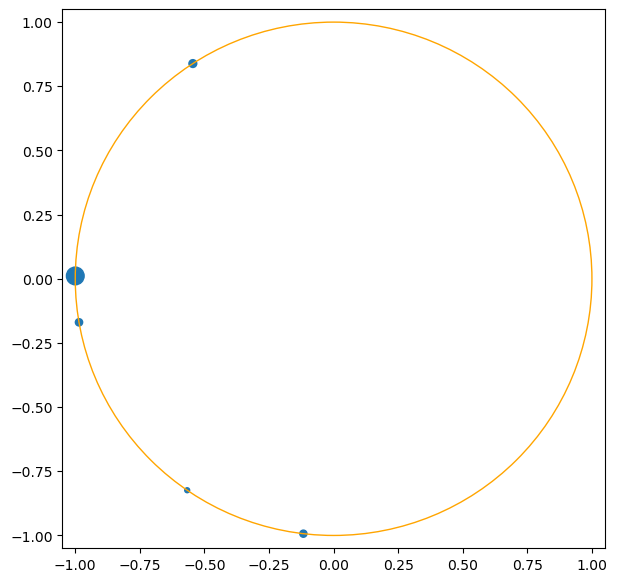

In [212]:
fig, ax = plt.subplots(figsize = (7,7))



ax.scatter(xi, zeta, s = np.sqrt(masses)*10)
circle = plt.Circle((0, 0), 1, color='orange', fill=False)  # `fill=False` for an unfilled circle
ax.add_artist(circle)
ax.set_xlim(-1.05,1.05)
ax.set_ylim(-1.05,1.05)

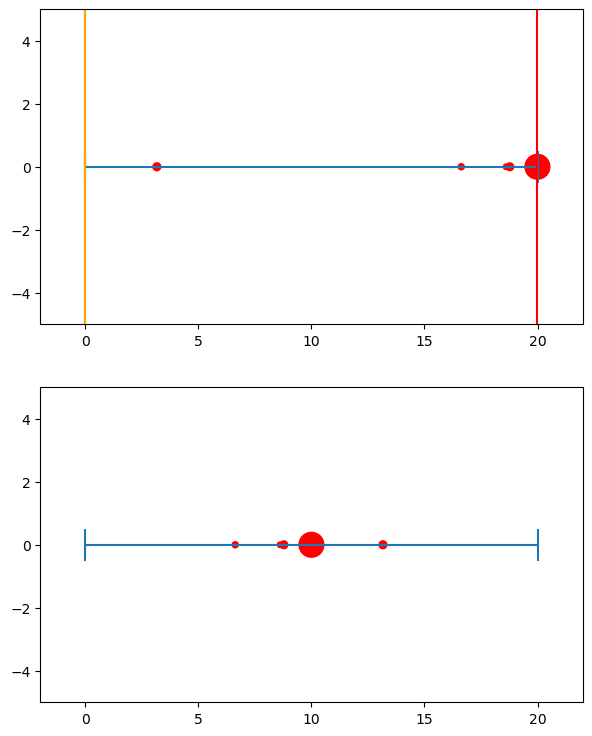

In [216]:
# set up the figure

fig,ax = plt.subplots(2,figsize = (7,9))

ax[0].set_xlim(-2,22)
ax[0].set_ylim(-5,5)

# draw lines
xmin = 0
xmax = 20
y1 = 0
height = 1

ax[0].hlines(y1, xmin, xmax)
ax[0].vlines(xmin, y1 - height / 2., y1 + height / 2.)
ax[0].vlines(xmax, y1 - height / 2., y1 + height / 2.)
ax[0].scatter(coords[:,0],np.zeros(5), s = np.sqrt(masses)*10, color = 'red')
ax[0].axvline(MDA_com, color = 'green')
ax[0].axvline(com_pi, color = 'red')
ax[0].axvline(corrected_com,color = 'orange')

ax[1].set_xlim(-2,22)
ax[1].set_ylim(-5,5)
ax[1].hlines(y1, xmin, xmax)
ax[1].vlines(xmin, y1 - height / 2., y1 + height / 2.)
ax[1].vlines(xmax, y1 - height / 2., y1 + height / 2.)
ax[1].scatter(wrapped,np.zeros(5),s = np.sqrt(masses)*10, color = 'red')
